In [1]:
import CalculatedFieldSubroutines as cfs

#

import numpy as np

import pandas as pd

#

import matplotlib.pyplot as plt

from pandasgui import show

#

import warnings

#

from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_score

In [2]:
warnings.filterwarnings( 'ignore' )

In [3]:
gmID_list = cfs.list_whitelisted_gmIDs()

topic_list = cfs.list_topics()

print( topic_list )

['/apollo/canbus/chassis', '/apollo/drive/event', '/apollo/sensor/gnss/best/pose', '/apollo/perception/traffic/light']


In [5]:
variables = [ 'brakePercentage', 'speedMps', 'throttlePercentage', 'steeringPercentage', 'LatLonTotalStdDev' ]

disengagement_df_list = []

for gmID in gmID_list:

    chassis_df = cfs.retrieve_gmID_topic( gmID, '/apollo/canbus/chassis' )

    best_pose_df = cfs.retrieve_gmID_topic( gmID, '/apollo/sensor/gnss/best/pose' )

    chassis_df = chassis_df.sort_values( 'time' )

    best_pose_df = best_pose_df.sort_values( 'time' )

    cfs.BinaryDrivingMode( chassis_df )

    cfs.TernaryDrivingModeTransition( chassis_df )

    cfs.LatLonTotalStdDev( best_pose_df )

    cfs.ChassisBestPoseMatchedTime( chassis_df, best_pose_df )

    merged_df = pd.merge( chassis_df, best_pose_df, on = 'ChassisBestPoseMatchedTime', how = 'inner' )

    merged_df = merged_df[ merged_df[ 'TernaryDrivingModeTransition' ] == -1 ]

    merged_df = merged_df[ variables ]

    disengagement_df_list.append( merged_df )

In [6]:
disengagement_df = pd.concat( disengagement_df_list )

disengagement_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2217 entries, 3060 to 47884
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   brakePercentage     2217 non-null   float64
 1   speedMps            2217 non-null   float64
 2   throttlePercentage  2217 non-null   float64
 3   steeringPercentage  2217 non-null   float64
 4   LatLonTotalStdDev   2217 non-null   float64
dtypes: float64(5)
memory usage: 103.9 KB


In [7]:
scaler = StandardScaler()

disengagement_data_scaler = scaler.fit( disengagement_df )

disengagement_data_scaled = disengagement_data_scaler.transform( disengagement_df )

In [11]:
def make_elbow_plot( df, n_clusters_range, find_silhouette_score = True ):

    min_num_of_clusters = n_clusters_range[ 0 ]

    max_num_of_clusters = n_clusters_range[ 1 ]

    num_of_clusters_array = np.array( [] )

    inertia_array = np.array( [] )

    silhouette_score_array = np.array( [] )

    for num_of_clusters in range( min_num_of_clusters, max_num_of_clusters ):

        num_of_clusters_array = np.append( num_of_clusters_array, num_of_clusters )

        kmeans_model = KMeans( n_clusters = num_of_clusters, 
                               init = 'k-means++', 
                               n_init = 10, 
                               max_iter = 300,
                               random_state = 0 )

        df_kmeans_clusters = kmeans_model.fit_predict( df )

        inertia = kmeans_model.inertia_

        inertia_array = np.append( inertia_array, inertia )

        if ( find_silhouette_score == True ):

            silhouette = silhouette_score( df, df_kmeans_clusters )

            silhouette_score_array = np.append( silhouette_score_array, silhouette )

    plt.plot( num_of_clusters_array, inertia_array, marker = '.', color = 'black' )

    plt.xlim( min_num_of_clusters - 1, max_num_of_clusters + 1 )

    plt.title( 'Elbow Plot' )

    plt.xlabel( 'Number of Clusters' )

    plt.ylabel( 'Inertia' )

    plt.show()

    if ( find_silhouette_score == True ):

        max_silhouette_score_cluster_num = int( np.argmax( silhouette_score_array ) ) + min_num_of_clusters

        return silhouette_score_array, max_silhouette_score_cluster_num

    else:

        return None, None

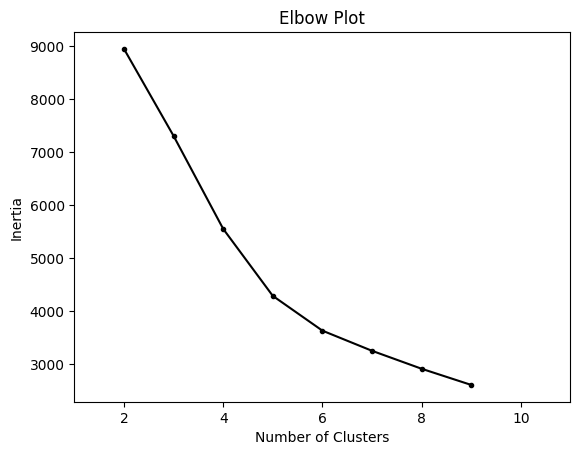

[0.33804954 0.33281549 0.33606403 0.37735405 0.31657989 0.3111448
 0.324506   0.32578695]
5


In [15]:
silhouette_score_array, max_silhouette_score_cluster_num = make_elbow_plot( disengagement_data_scaled, 
                                                                            ( 2, 10 ),
                                                                            find_silhouette_score = True )

print( silhouette_score_array )

print( max_silhouette_score_cluster_num )

In [31]:
num_of_clusters = max_silhouette_score_cluster_num

kmeans_model = KMeans( n_clusters = num_of_clusters, 
                       init = 'k-means++', 
                       n_init = 10, 
                       max_iter = 300, 
                       random_state = 0 )

disengagement_data_scaled_kmeans_clusters = kmeans_model.fit_predict( disengagement_data_scaled )

disengagement_df[ 'cluster_num' ] = disengagement_data_scaled_kmeans_clusters

print( list( disengagement_df.columns ) )

for index, centroid in enumerate( disengagement_data_scaler.inverse_transform( kmeans_model.cluster_centers_ ) ):

    cluster_size = len( disengagement_df[ disengagement_df[ 'cluster_num' ] == index ][ 'cluster_num' ] )

    print( f'Cluster #: { index }' )
    print( f'Cluster Size: { cluster_size }' )
    print( f'Centroid Location: { centroid }' )
    print( '' )

['brakePercentage', 'speedMps', 'throttlePercentage', 'steeringPercentage', 'LatLonTotalStdDev', 'cluster_num']
Cluster #: 0
Cluster Size: 388
Centroid Location: [31.74304124  9.61663809  0.11494845 -0.97814659  0.22494323]

Cluster #: 1
Cluster Size: 506
Centroid Location: [ 1.06166008  8.8698723  47.82055336  0.31035359  0.32477987]

Cluster #: 2
Cluster Size: 1173
Centroid Location: [ 1.50392157 14.91940305  3.60383632  0.68668938  0.56603255]

Cluster #: 3
Cluster Size: 149
Centroid Location: [  8.9852349    3.40443813   4.88053691 -32.61150983   0.1560412 ]

Cluster #: 4
Cluster Size: 1
Centroid Location: [  0.          10.76         0.           2.87953    173.56011566]



In [17]:
disengagement_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2217 entries, 3060 to 47884
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   brakePercentage     2217 non-null   float64
 1   speedMps            2217 non-null   float64
 2   throttlePercentage  2217 non-null   float64
 3   steeringPercentage  2217 non-null   float64
 4   LatLonTotalStdDev   2217 non-null   float64
 5   cluster_num         2217 non-null   int32  
dtypes: float64(5), int32(1)
memory usage: 112.6 KB


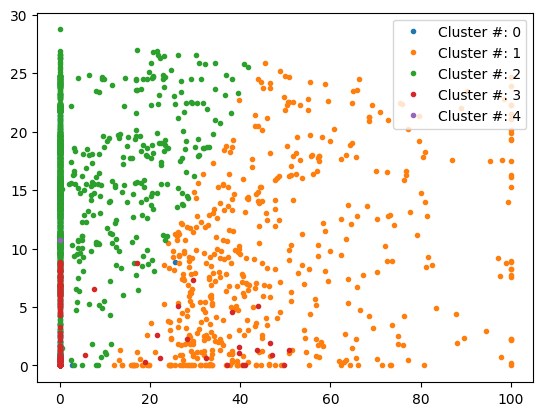

In [36]:
for cluster_num in range( num_of_clusters ):

    x_array = disengagement_df[ disengagement_df.columns[ 2 ] ][ disengagement_df[ 'cluster_num' ] == cluster_num ]

    y_array = disengagement_df[ disengagement_df.columns[ 1 ] ][ disengagement_df[ 'cluster_num' ] == cluster_num ]

    plt.plot( x_array, y_array, marker = '.', ls = '', label = f'Cluster #: { cluster_num }' )

plt.legend()

plt.show()